In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

import yfinance as yf

from datetime import datetime, timedelta

import requests
import json

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
import yfinance as yf
end_date = datetime.datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.datetime.today() - datetime.timedelta(days=365*20)).strftime('%Y-%m-%d')
spy_data = yf.Ticker('SPY').history(start=start_date, end=end_date)
ndaq_data= yf.Ticker('NDAQ').history(start=start_date, end=end_date)

# Extract Bond and Commodity Data
bond_data = yf.download('BOND', start=start_date, end=end_date)
vigit_data = yf.download('VGIT', start=start_date, end=end_date)
xle_data = yf.download('XLE', start=start_date, end=end_date)
iau_data = yf.download('IAU', start=start_date, end=end_date)
bitcoin_data  = yf.download('BTC-USD', start=start_date, end=end_date)
etm_data =  yf.download('ETH-USD', start=start_date, end=end_date)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [33]:
spy_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2003-11-04 00:00:00-05:00,72.243475,72.434324,71.964019,72.086708,31421600,0.0,0.0,0.0
2003-11-05 00:00:00-05:00,71.902697,72.229870,71.500551,72.141258,33558800,0.0,0.0,0.0
2003-11-06 00:00:00-05:00,71.977730,72.550283,71.636926,72.523018,28392300,0.0,0.0,0.0
2003-11-07 00:00:00-05:00,72.686559,72.741089,71.957240,71.984505,31723200,0.0,0.0,0.0
2003-11-10 00:00:00-05:00,72.073089,72.141249,71.575519,71.691391,25530800,0.0,0.0,0.0


In [65]:

etfs= [spy_data, ndaq_data]
other_assets = [bond_data, vigit_data, xle_data, iau_data, bitcoin_data, etm_data]

**LSTM PRICE PREDICTION**

In [3]:
import pandas_ta as ta
spy_data["RSI"] = ta.rsi(spy_data.Close, length=15)
#Exponential moving average with different time span
spy_data["EMAF"] = ta.ema(spy_data.Close, length=20)
spy_data["EMAM"] = ta.ema(spy_data.Close, length=100)
spy_data["EMAS"] = ta.ema(spy_data.Close, length=150)

#next day target price
spy_data["Target"] = (spy_data['Adj Close']-spy_data["Open"]).shift(-1)
spy_data["TargetClass"] = [1 if spy_data["Target"][i] > 0 else 0 for i in range(len(spy_data))]
spy_data["NextCloseTarget"] = spy_data["Adj Close"].shift(-1)


C:\Users\srdhr\AppData\Local\Temp\ipykernel_22068\3948879117.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tesla_data["TargetClass"] = [1 if tesla_data["Target"][i] > 0 else 0 for i in range(len(tesla_data))]


In [4]:
spy_data.dropna(inplace=True)
spy_data.reset_index(inplace=True)
spy_data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [43]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam
 # Build and train the LSTM model
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

def fit_LSTM(data):
# Extract the 'Close' prices as the target variable
    prices = data.values.reshape(-1, 1)

    # Normalize the data using Min-Max scaling
    scaler = MinMaxScaler()
    prices_scaled = scaler.fit_transform(prices)

    # Define a function to create sequences for LSTM training
    def create_sequences(data, sequence_length):
        X, y = [], []
        for i in range(len(data) - sequence_length):
            X.append(data[i:i+sequence_length])
            y.append(data[i+sequence_length])
        return np.array(X), np.array(y)

    # Hyperparameters
    sequence_length = 60  # Adjust as needed
    train_ratio = 0.7
    validation_ratio = 0.1
    test_ratio = 0.2

    # Calculate split indices
    total_len = len(prices_scaled)
    train_split = int(total_len * train_ratio)
    validation_split = int(total_len * (train_ratio + validation_ratio))

    # Create sequences for training
    X, y = create_sequences(prices_scaled, sequence_length)

    # Split data into training, validation, and testing sets
    X_train, X_val, X_test = X[:train_split], X[train_split:validation_split], X[validation_split:]
    y_train, y_val, y_test = y[:train_split], y[train_split:validation_split], y[validation_split:]
 
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(units=1))

    es = EarlyStopping(patience=10, verbose=3)

    model.compile(loss='mse',
                optimizer=Adam(),
                metrics=['mean_absolute_error'])
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=2, validation_data=(X_val, y_val), callbacks=es)

    y_pred = model.predict(X_test)

    # Inverse transform the scaled data to get actual prices
    y_test_actual = scaler.inverse_transform(y_test)
    y_pred_actual = scaler.inverse_transform(y_pred)

    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = np.sqrt(mse)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    lst_output=[]
    n_steps=60
    i=0
    x_input = prices_scaled[validation_split:][-60:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()


    while(i<30):
        
        if(len(temp_input)>60):
            
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, n_steps,1))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            print(len(temp_input))
            lst_output.extend(yhat.tolist())
            i=i+1
    
    lst_output = scaler.inverse_transform(np.array(lst_output))
    
    return model, lst_output, scaler, y_pred_actual
        


In [63]:

etf_asset_name  = ['SPY', 'NDAQ']
other_asset_name = ['BOND', 'VIGIT', 'XLE', 'IAU', 'BITCOIN', 'ETM']

In [ ]:
import pickle
counter = 0
for asset in etfs:
    model, forecast, scaler, y_pred_actual = fit_LSTM(asset['Close'])
    pickle.dump(model, open(f'{etf_asset_name[counter]}_model.pkl', 'wb'))
    
    counter+=1
    

In [67]:
import pickle
counter = 0
for asset in other_assets:
    model, forecast, scaler, y_pred_actual = fit_LSTM(asset['Adj Close'])
    pickle.dump(model, open(f'{other_asset_name[counter]}_model.pkl', 'wb'))
    counter+=1
    

Epoch 1/100
65/65 - 5s - loss: 0.0807 - mean_absolute_error: 0.1981 - val_loss: 0.0018 - val_mean_absolute_error: 0.0397 - 5s/epoch - 72ms/step
Epoch 2/100
65/65 - 2s - loss: 0.0012 - mean_absolute_error: 0.0265 - val_loss: 0.0071 - val_mean_absolute_error: 0.0812 - 2s/epoch - 30ms/step
Epoch 3/100
65/65 - 2s - loss: 5.7538e-04 - mean_absolute_error: 0.0167 - val_loss: 0.0048 - val_mean_absolute_error: 0.0671 - 2s/epoch - 31ms/step
Epoch 4/100
65/65 - 2s - loss: 3.3342e-04 - mean_absolute_error: 0.0114 - val_loss: 0.0019 - val_mean_absolute_error: 0.0408 - 2s/epoch - 30ms/step
Epoch 5/100
65/65 - 2s - loss: 2.9704e-04 - mean_absolute_error: 0.0105 - val_loss: 0.0018 - val_mean_absolute_error: 0.0406 - 2s/epoch - 30ms/step
Epoch 6/100
65/65 - 2s - loss: 3.0297e-04 - mean_absolute_error: 0.0107 - val_loss: 7.4787e-04 - val_mean_absolute_error: 0.0243 - 2s/epoch - 30ms/step
Epoch 7/100
65/65 - 2s - loss: 2.8940e-04 - mean_absolute_error: 0.0106 - val_loss: 0.0011 - val_mean_absolute_error

In [72]:
#code to load picker files


model_1 = pickle.load(open('SPY_model.pkl' , 'rb'))
model_2 = pickle.load(open('NDAQ_model.pkl' , 'rb'))
model_3 = pickle.load(open('BOND_model.pkl' , 'rb'))
model_4 = pickle.load(open('VIGIT_model.pkl' , 'rb'))
model_5 = pickle.load(open('XLE_model.pkl' , 'rb'))
model_6 = pickle.load(open('IAU_model.pkl' , 'rb'))
model_7 = pickle.load(open('BITCOIN_model.pkl' , 'rb'))
model_8 = pickle.load(open('ETM_model.pkl' , 'rb'))


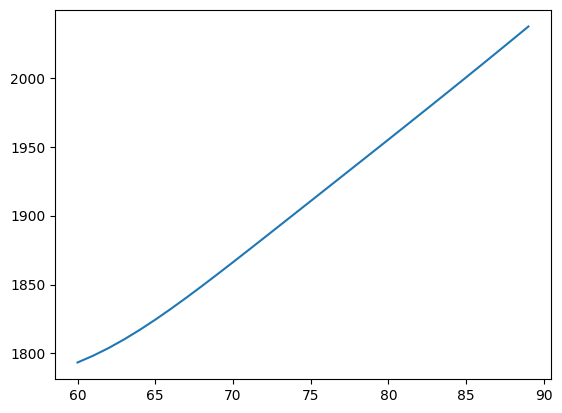

In [73]:

plt.plot(np.arange(60,90),forecast)